## Import some pkgs

In [142]:
import sys
sys.path.append("../../mypkg")

import scipy
import itertools

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange
from scipy.io import loadmat
from functools import partial
from easydict import EasyDict as edict
from collections import defaultdict as ddict

In [143]:
# SBI and torch
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import analysis
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as sutils

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

In [144]:
# my own fns
from brain import Brain
from FC_utils import build_fc_freq_m
from constants import RES_ROOT, DATA_ROOT, FIG_ROOT
from utils.misc import load_pkl, save_pkl
from utils.reparam import theta_raw_2out, logistic_np, logistic_torch
from utils.measures import geodesic_dist, reg_R_fn, lin_R_fn

plt.style.use(FIG_ROOT/"base.mplstyle")

## Some fns

In [7]:
_minmax_vec = lambda x: (x-np.min(x))/(np.max(x)-np.min(x))

<function __main__.<lambda>(x)>

In [8]:
# transfer vec to a sym mat
def _vec_2mat(vec):
    mat = np.zeros((68, 68))
    mat[np.triu_indices(68, k = 1)] = vec
    mat = mat + mat.T
    return mat

In [9]:
## t test for each band
def paired_ttest(band, fc_types):
    typ_idx = fc_types.index(band)
    a = corrs_all["allbands"][:, typ_idx] 
    b = corrs_all[band]
    res = scipy.stats.ttest_rel(a, b)
    return res

def twosps_ttest(band, fc_types):
    typ_idx = fc_types.index(band)
    a = corrs_all["allbands"][:, typ_idx] 
    b = corrs_all[band]
    res = scipy.stats.ttest_ind(a, b)
    return res

### Some parameters

In [10]:
_paras = edict()
_paras.delta = [2, 3.5]
_paras.theta = [4, 7]
_paras.alpha = [8, 12]
_paras.beta = [13, 20]
_paras.beta_l = [13, 20]
_paras.beta_h = [15, 25]
_paras.cols = ["#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02",]
_paras.markers = ["o", "h", "*", "+"]
_paras.xaxis_labs = [r"$\delta$", r"$\theta$", r"$\alpha$", r"$\beta$"]
_paras.barh = 0.05

In [11]:
# Parameter bounds for optimization
v_lower = 3.5-1.8
v_upper = 3.5+1.8
bnds = ((0.005,0.030), (v_lower,v_upper), (0.1,1.0))
#tauG,speed,alpha

((0.005, 0.03), (1.7, 5.3), (0.1, 1.0))

In [195]:
paras = edict()

paras.fc_types = ["delta", "theta", "alpha", "beta_l"]
paras.epoch = ""
paras.freqranges =  [np.linspace(_paras[fc_type][0], _paras[fc_type][1], 5) 
                     for fc_type in paras.fc_types]
print(paras.freqranges)
paras.fs = 600
paras.num_nodes = 86 # Number of cortical (68) + subcortical nodes
paras.par_low =  np.array([ix[0] for ix in bnds])
paras.par_high = np.array([ix[1] for ix in bnds])
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.prior_sd = 10
paras.add_v = 0.05

paras.dirs = edict()
for fc_type in paras.fc_types:
    paras.dirs[fc_type] = (RES_ROOT/(f"newsgmws1_posteriorMRmul_"+
                                     f"{fc_type}_num1000_densitynsf_MR3_noise_sd80_addv5"))
for fc_type in paras.fc_types:
    paras.dirs[fc_type+"w0"] = (RES_ROOT/(f"newsgm_posteriorMRmul_"+
                                     f"{fc_type}_num1000_densitynsf_MR3_noise_sd80_addv5"))
for fc_type in paras.fc_types:
    paras.dirs[fc_type+"w1"] = (RES_ROOT/(f"newsgm1w1_posteriorMRmul_"+
                                     f"{fc_type}_num1000_densitynsf_MR3_noise_sd80_addv5"))


[array([2.   , 2.375, 2.75 , 3.125, 3.5  ]), array([4.  , 4.75, 5.5 , 6.25, 7.  ]), array([ 8.,  9., 10., 11., 12.]), array([13.  , 14.75, 16.5 , 18.25, 20.  ])]


In [196]:
# fn for reparemetering
_map_fn_torch = partial(logistic_torch, k=0.1)
_theta_raw_2out = partial(theta_raw_2out, map_fn=partial(logistic_np, k=0.1))

functools.partial(<function theta_raw_2out at 0x7fde2339e160>, map_fn=functools.partial(<function logistic_np at 0x7fde2339e0d0>, k=0.1))

### Load the data

In [197]:
# SC
ind_conn_xr = xr.open_dataarray(DATA_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values

# PSD
ind_psd_xr = xr.open_dataarray(DATA_ROOT/'individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
fvec = ind_psd_xr["frequencies"].values;

In [198]:

def _add_v2con(cur_ind_conn):
    cur_ind_conn = cur_ind_conn.copy()
    add_v = np.max(cur_ind_conn)*paras.add_v # tuning 0.1
    np.fill_diagonal(cur_ind_conn[:34, 34:68], np.diag(cur_ind_conn[:34, 34:68]) + add_v)
    np.fill_diagonal(cur_ind_conn[34:68, :34], np.diag(cur_ind_conn[34:68, :34]) + add_v)
    np.fill_diagonal(cur_ind_conn[68:77, 77:], np.diag(cur_ind_conn[68:77, 77:]) + add_v)
    np.fill_diagonal(cur_ind_conn[77:, 68:77], np.diag(cur_ind_conn[77:, 68:77]) + add_v)
    return cur_ind_conn


if paras.add_v != 0:
    print(f"Add {paras.add_v} on diag")
    ind_conn_adds = [_add_v2con(ind_conn[:, :, ix]) for ix in range(36)]
    ind_conn = np.transpose(np.array(ind_conn_adds), (1, 2, 0))

Add 0.05 on diag


In [200]:
# Load true MEG FC time series:
true_FCs = []
for fc_type in paras.fc_types:
    dataPath = DATA_ROOT/f'./{paras.epoch}MEG_FC_{fc_type}_DK_networks_coh.mat'
    data = loadmat(dataPath);
    true_FC = data[f"MEG_{fc_type}_FC_networks_coh"]
    true_FCs.append(true_FC)

true_FC.shape

(68, 68, 36)

## Calculate the metrics

linR, pearsons R and geodesic dist

In [201]:
def divideFc(fc):
    """Divide the FC into three blocks and vector them
    """
    size_fc = len(fc)
    hs_fc = int(size_fc/2)
    fc_block1 = fc[:hs_fc, :hs_fc]
    fc_block2 = fc[hs_fc:, hs_fc:];
    fc_block3 = fc[:hs_fc, hs_fc:];
    vec1 = _minmax_vec(fc_block1[np.triu_indices(hs_fc, k = 1)])
    vec2 = _minmax_vec(fc_block2[np.triu_indices(hs_fc, k = 1)])
    vec3 = _minmax_vec(fc_block3.flatten())
    return vec1, vec2, vec3

def cal_metrics(fc1, fc2):
    """Calculate the distance between fc1 and fc2, including
        1. geodesic dist
        2. pearson's R
        3. lin R
        4. pearson's R after divide the FC into three blocks
        5. lin R after divide the FC into three blocks
    """
    fc1 = fc1.astype(np.float64)
    fc2 = fc2.astype(np.float64)
    size_fc = len(fc1)
    
    # for geodedic
    fc1_g = fc1/np.linalg.norm(fc1) + np.eye(size_fc)
    fc2_g = fc2/np.linalg.norm(fc2) + np.eye(size_fc)
    
    fc1_c = _minmax_vec(fc1[np.triu_indices(size_fc, k=1)]).reshape(1, -1)
    fc2_c = _minmax_vec(fc2[np.triu_indices(size_fc, k=1)]).reshape(1, -1)
    
    # all metrics
    geo_dist = geodesic_dist(fc1_g, fc2_g)
    reg_r = reg_R_fn(fc1_c, fc2_c)
    lin_r = lin_R_fn(fc1_c, fc2_c)
    
    # block wise metrics
    blocks1 = divideFc(fc1)
    blocks2 = divideFc(fc2)
    reg_r_block = [reg_R_fn(vec1.reshape(1, -1), vec2.reshape(1, -1))[0] 
                   for vec1, vec2 in zip(blocks1, blocks2)]
    lin_r_block = [lin_R_fn(vec1.reshape(1, -1), vec2.reshape(1, -1))[0] 
                   for vec1, vec2 in zip(blocks1, blocks2)]
    
    res = edict()
    res.geo_dist = geo_dist
    res.reg_r = reg_r[0]
    res.lin_r = lin_r[0]
    res.reg_r_block = np.mean(reg_r_block)
    res.lin_r_block = np.mean(lin_r_block)
    return res

def cal_metrics_batch(fc1s, fc2s):
    """fc1s, fc2s: num_fc x 68 x 68
    """
    ress = ddict(list)
    for ix in range(len(fc1s)):
        fc_t = fc2s[ix]
        fc_e = fc1s[ix]
        res = cal_metrics(fc_t, fc_e)
        for key, v in res.items():
            ress[key].append(v)
    
    return ress

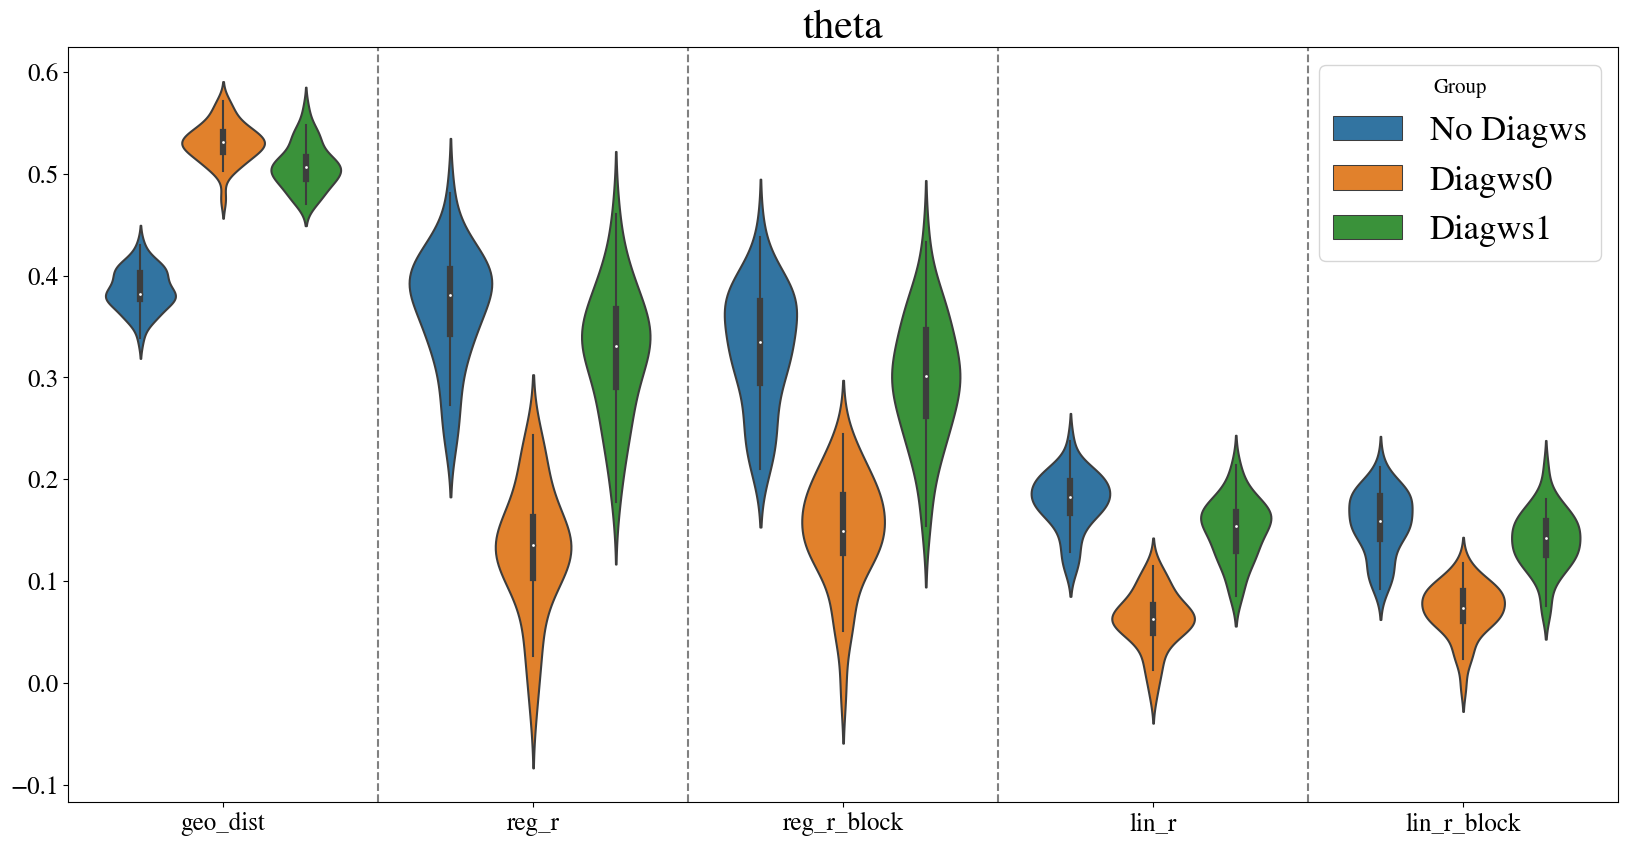

In [203]:
typ = "theta"
is_w0 = True
true_FC = true_FCs[paras.fc_types.index(typ)];
fcs_true = true_FC.transpose(2, 0, 1)


fil = list(paras.dirs[typ].glob("inf_res_fb.pkl"))[0]
cur_res = load_pkl(fil, verbose=False);
fcs_est = np.array(cur_res.est_FCs);

if is_w0:
    fil = list(paras.dirs[typ+"w0"].glob("inf_res_fb.pkl"))[0]
    cur_res = load_pkl(fil, verbose=False);
    fcs_est_w0 = np.array(cur_res.est_FCs);

fil = list(paras.dirs[typ+"w1"].glob("inf_res_fb.pkl"))[0]
cur_res = load_pkl(fil, verbose=False);
fcs_est_w1 = np.array(cur_res.est_FCs);

ress = cal_metrics_batch(fcs_true, fcs_est)
ress_w0 = cal_metrics_batch(fcs_true, fcs_est_w0)
ress_w1 = cal_metrics_batch(fcs_true, fcs_est_w1);


data = []
key_names = ['geo_dist', 'reg_r', 'reg_r_block', 'lin_r', 'lin_r_block']
for key in key_names:
    for value in ress[key]:
        data.append({'Group': 'No Diagws', 'Key': key, 'Value': value})
        
if is_w0:
    for key in key_names:
        for value in ress_w0[key]:
            data.append({'Group': 'Diagws0', 'Key': key, 'Value': value})
for key in key_names:
    for value in ress_w1[key]:
        data.append({'Group': 'Diagws1', 'Key': key, 'Value': value})
    
df = pd.DataFrame(data)

plt.figure(figsize=[20, 10])
plt.title(f"{typ}", fontsize=30)
ax = sns.violinplot(x='Key', y='Value', hue='Group', data=df, split=False)
plt.xlabel("")
plt.ylabel("")

keys = df['Key'].unique()
for key_idx, key in enumerate(keys):
    if key_idx < len(keys) - 1:
        ax.axvline(x=key_idx + 0.5, color='grey', linestyle='--')
        
plt.savefig(FIG_ROOT/f"{typ}_cmp.jpg")